# Inferring parameters of SDEs using a Euler-Maruyama scheme

_This notebook is derived from a presentation prepared for the Theoretical Neuroscience Group, Institute of Systems Neuroscience at Aix-Marseile University._

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt 
import scipy
from pymc3.distributions.timeseries import EulerMaruyama


plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


## Toy model 1

Here's a scalar linear SDE in symbolic form

$ dX_t = \lambda X_t + \sigma^2 dW_t $

discretized with the Euler-Maruyama scheme

In [2]:
# parameters
λ = -0.78
σ2 = 5e-3
N = 200
dt = 1e-1

# time series
x = 0.1
x_t = []

# simulate
for i in range(N):
    x += dt * λ * x + np.sqrt(dt) * σ2 * np.random.randn()
    x_t.append(x)
    
x_t = np.array(x_t)

# z_t noisy observation
z_t = x_t + np.random.randn(x_t.size) * 5e-3

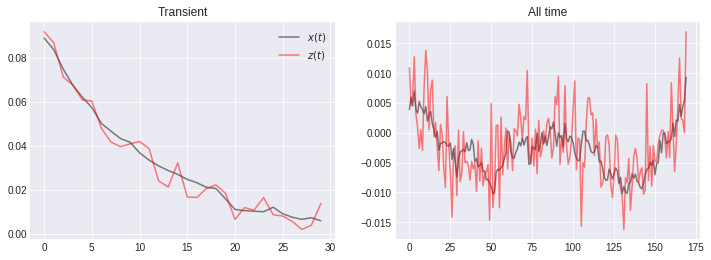

In [3]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(x_t[:30], 'k', label='$x(t)$', alpha=0.5)
axes[0].plot(z_t[:30], 'r', label='$z(t)$', alpha=0.5)
axes[0].set_title('Transient')
axes[0].legend()

axes[1].plot(x_t[30:], 'k', label='$x(t)$', alpha=0.5)
axes[1].plot(z_t[30:], 'r', label='$z(t)$', alpha=0.5)
axes[1].set_title('All time');

What is the inference we want to make? Since we've made a noisy observation of the generated time series, we need to estimate both $x(t)$ and $\lambda$.

First, we rewrite our SDE as a function returning a tuple of the drift and diffusion coefficients

In [4]:
def lin_sde(x, lam):
    return lam * x, σ2

Next, we describe the probability model as a set of three stochastic variables, `lam`, `xh`, and `zh`:

In [5]:
with pm.Model() as model:
    
    # uniform prior, but we know it must be negative
    lam = pm.Flat('lam')
    
    # "hidden states" following a linear SDE distribution
    # parametrized by time step (det. variable) and lam (random variable)
    xh = EulerMaruyama('xh', dt, lin_sde, (lam, ), shape=N, testval=x_t)
    
    # predicted observation
    zh = pm.Normal('zh', mu=xh, sd=5e-3, observed=z_t)

Once the model is constructed, we perform inference, i.e. sample from the posterior distribution, in the following steps:

In [6]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xh, lam]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:43<00:00, 12.03draws/s]
The acceptance probability does not match the target. It is 0.9329569003963567, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9709907858712041, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9177029482124184, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9903283915568493, but should be close to 0.8. Try to increase the number of tuning steps.


Next, we plot some basic statistics on the samples from the posterior,

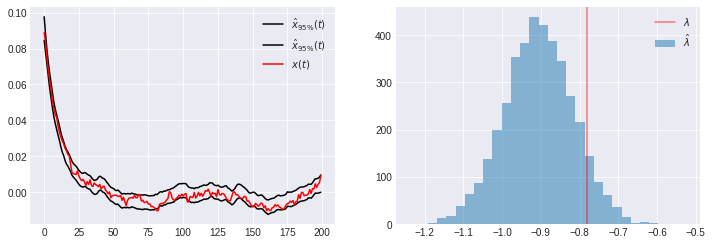

In [7]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(np.percentile(trace[xh], [2.5, 97.5], axis=0).T, 'k', label='$\hat{x}_{95\%}(t)$')
axes[0].plot(x_t, 'r', label='$x(t)$')
axes[0].legend()

axes[1].hist(trace[lam], 30, label='$\hat{\lambda}$', alpha=0.5)
axes[1].axvline(λ, color='r', label='$\lambda$', alpha=0.5)
axes[1].legend();

A model can fit the data precisely and still be wrong; we need to use _posterior predictive checks_ to assess if, under our fit model, the data our likely.

In other words, we 
- assume the model is correct
- simulate new observations
- check that the new observations fit with the original data

100%|██████████| 1000/1000 [00:00<00:00, 2285.01it/s]


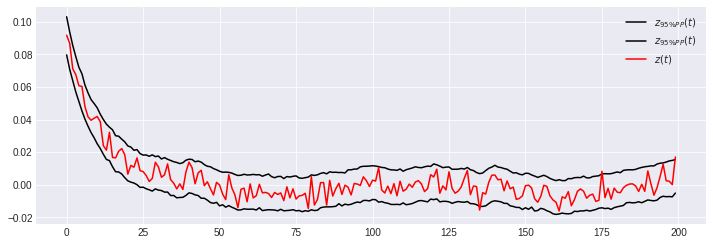

In [8]:
# generate trace from posterior
ppc_trace = pm.sample_ppc(trace, model=model)

# plot with data
_, ax = plt.subplots(figsize=(12, 4))

ax.plot(np.percentile(ppc_trace['zh'], [2.5, 97.5], axis=0).T, 'k', label=r'$z_{95\% PP}(t)$')
ax.plot(z_t, 'r', label='$z(t)$')
ax.legend();

Note that 

- inference also estimates the initial conditions
- the observed data $z(t)$ lies fully within the 95% interval of the PPC.
- there are many other ways of evaluating fit

### Toy model 2

As the next model, let's use a 2D deterministic oscillator, 
\begin{align}
\dot{x} &= \tau (x - x^3/3 + y) \\
\dot{y} &= \frac{1}{\tau} (a - x)
\end{align}

with noisy observation $z(t) = m x + (1 - m) y + N(0, 0.05)$.

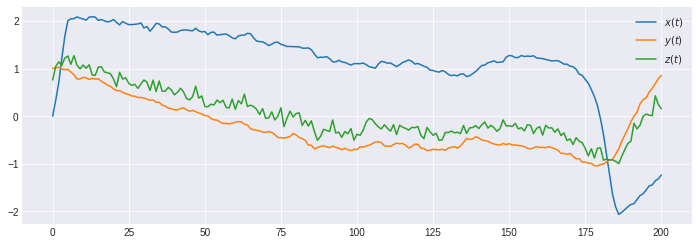

In [9]:
N, τ, a, m, σ2 = 200, 3.0, 1.05, 0.2, 1e-1
xs, ys = [0.0], [1.0]
for _ in range(N):
    x, y = xs[-1], ys[-1]
    dx = τ * (x - x**3.0/3.0 + y)
    dy = (1.0 / τ) * (a - x)
    xs.append(x + dt * dx + np.sqrt(dt) * σ2 * np.random.randn())
    ys.append(y + dt * dy + np.sqrt(dt) * σ2 * np.random.randn())
xs, ys = np.array(xs), np.array(ys)
zs = m * xs + (1 - m) * ys + np.random.randn(xs.size) * 0.1

_, ax = plt.subplots(figsize=(12, 4))
ax.plot(xs, label='$x(t)$')
ax.plot(ys, label='$y(t)$')
ax.plot(zs, label='$z(t)$')
ax.legend();

Now, estimate the hidden states $x(t)$ and $y(t)$, as well as parameters $\tau$, $a$ and $m$.

As before, we rewrite our SDE as a function returned drift & diffusion coefficients:

In [10]:
def osc_sde(xy, τ, a):
    x, y = xy[:, 0], xy[:, 1]
    dx = τ * (x - x**3.0/3.0 + y)
    dy = (1.0 / τ) * (a - x)
    dxy = tt.stack([dx, dy], axis=0).T
    return dxy, σ2

As before, the Euler-Maruyama discretization of the SDE is written as a prediction of the state at step $i+1$ based on the state at step $i$.

We can now write our statistical model as before, with uninformative priors on $\tau$, $a$ and $m$:

In [11]:
xys = np.vstack((xs, ys)).T


with pm.Model() as model:
    τh = pm.Uniform('τh', lower=0.1, upper=5.0)
    ah = pm.Uniform('ah', lower=0.5, upper=1.5)
    mh = pm.Uniform('mh', lower=0.0, upper=1.0)
    xyh = EulerMaruyama('xyh', dt, osc_sde, (τh, ah), shape=xys.shape, testval=xys)
    zh = pm.Normal('zh', mu=mh * xyh[:, 0] + (1 - mh) * xyh[:, 1], sd=0.1, observed=zs)

As with the linear SDE, we 1) find a MAP estimate, 2) warm up and 3) sample from the probability mass:

In [12]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xyh, mh, ah, τh]
Sampling 4 chains: 100%|██████████| 10000/10000 [02:10<00:00, 20.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


Again, the result is a set of samples from the posterior, including our parameters of interest but also the hidden states

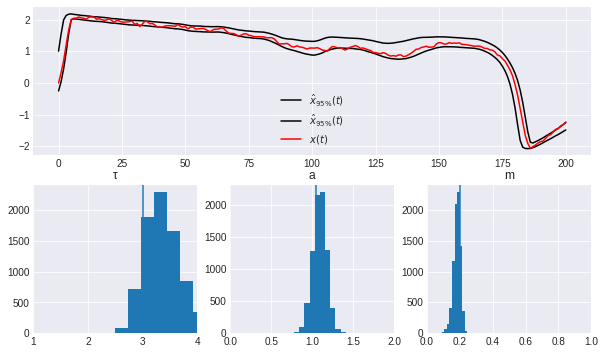

In [13]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(np.percentile(trace[xyh][..., 0], [2.5, 97.5], axis=0).T, 'k', label='$\hat{x}_{95\%}(t)$')
plt.plot(xs, 'r', label='$x(t)$')
plt.legend(loc=0)
plt.subplot(234), plt.hist(trace['τh']), plt.axvline(τ), plt.xlim([1.0, 4.0]), plt.title('τ')
plt.subplot(235), plt.hist(trace['ah']), plt.axvline(a), plt.xlim([0, 2.0]), plt.title('a')
plt.subplot(236), plt.hist(trace['mh']), plt.axvline(m), plt.xlim([0, 1]), plt.title('m');


Again, we can perform a posterior predictive check, that our data are likely given the fit model

100%|██████████| 2000/2000 [00:00<00:00, 2423.42it/s]


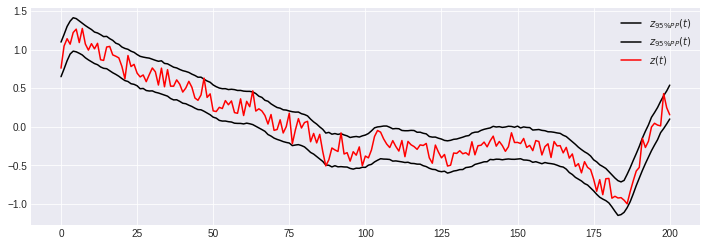

In [14]:
# generate trace from posterior
ppc_trace = pm.sample_ppc(trace, model=model)

# plot with data
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.percentile(ppc_trace['zh'], [2.5, 97.5], axis=0).T, 'k', label=r'$z_{95\% PP}(t)$')
ax.plot(zs, 'r', label='$z(t)$')
ax.legend();